In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from matplotlib import pyplot as plt
import numpy as np

In [3]:
class ODE1(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss") 
        
    @property
    def metrics(self):
        return [self.loss_tracker] 
    
    
    def train_step(self, data):
        batch_size = 100 
        
        x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)
        
        
        with tf.GradientTape() as tape:
            
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                y_pred = self(x, training=True)
                dy =tape2.gradient(y_pred, x)
                x_o = tf.zeros((batch_size,1))
                y_o = self(x_o, training=True)
                eq = x*dy + y_pred - (x**2)*(tf.math.cos(x))
                ic = y_o + 0.
                loss = keras.losses.mean_squared_error(0.,eq) + keras.losses.mean_squared_error(0., ic)
                
        #aplica los gradientes        
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        
        #actualiza metricas
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    


In [11]:
    model = ODE1()
    
    model.add(Dense(20,activation ='tanh', input_shape=(1,)))
    model.add(Dense(50, activation ='tanh'))
    model.add(Dense(80, activation ='tanh'))
    model.add(Dense(50, activation ='tanh'))
    model.add(Dense(10, activation ='tanh'))
    model.add(Dense(1, activation ='tanh'))
    model.add(Dense(1, activation ='linear'))
    
    
    
    model.summary()
    
    model.compile(optimizer=Adam(), metrics=['loss'])
    
    x=tf.linspace(-5,5,100)
    history = model.fit(x,epochs=4000,verbose=0)
    
    x_testv = tf.linspace(-5,5,100)
    a=model.predict(x_testv)

Model: "ode1_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 20)                40        
                                                                 
 dense_22 (Dense)            (None, 50)                1050      
                                                                 
 dense_23 (Dense)            (None, 80)                4080      
                                                                 
 dense_24 (Dense)            (None, 50)                4050      
                                                                 
 dense_25 (Dense)            (None, 10)                510       
                                                                 
 dense_26 (Dense)            (None, 1)                 11        
                                                                 
 dense_27 (Dense)            (None, 1)                 2    

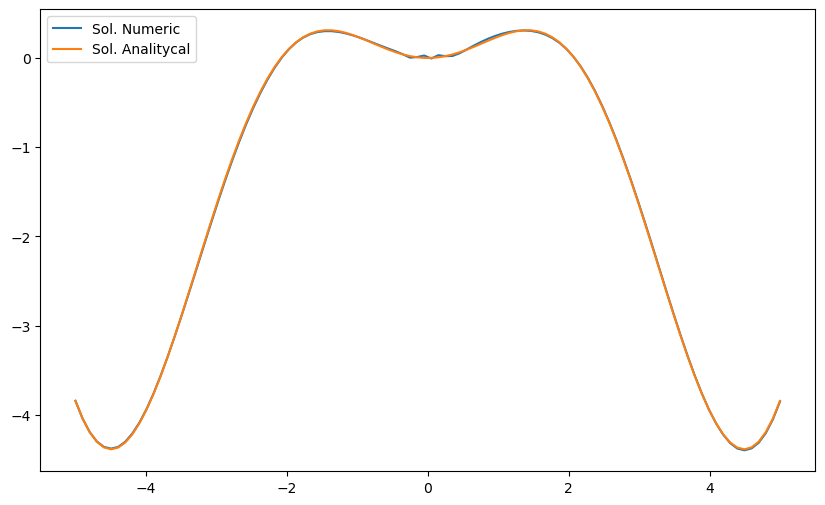

In [12]:
plt.figure(figsize=(10,6))
plt.plot(x_testv,a)
plt.plot( x_testv,x*np.sin(x)+2*np.cos(x)-2*np.sin(x)/x)
legend = ['Sol. Numeric','Sol. Analitycal']
plt.legend(loc='upper left', labels= legend)
plt.show()
model.save("T3_RNA_EDO1.h5")

In [6]:
class ODE2(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss") #loss_tracker pude ser cambiada por mivalor_de_costo o como queramos
        
        
    @property
    def metrics(self):
        return [self.loss_tracker] #igual cambia el loss_tracker
    
    
    def train_step(self, data):
        batch_size = tf.shape(data)[0]
     
        x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)
        x_o = tf.zeros((batch_size,1))
        
        
        with tf.GradientTape() as tape:
            
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x)
                
                with tf.GradientTape(persistent=True) as tape3:
                    tape3.watch(x)
                    tape3.watch(x_o)
                    y_pred = self(x, training=True)
                    y_o = self(x_o, training=True)
                        
                dy_dx = tape3.gradient(y_pred, x)
                dy_dxo = tape3.gradient(y_o, x_o)
                
            dy2_dx2 = tape2.gradient(dy_dx, x)
            
            eq = dy2_dx2 + y_pred
            ic = y_o -1. 
            ic2 = dy_dxo + 0.5
            loss = keras.losses.mean_squared_error(0.,eq) + keras.losses.mean_squared_error(0., ic)+ keras.losses.mean_squared_error(0.,ic2)
                
            
            
                
        #aplica los gradientes        
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        
        #actualiza metricas
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    


In [7]:
    model = ODE2()
    
    model.add(Dense(10,activation ='tanh', input_shape=(1,)))
    model.add(Dense(50, activation ='tanh'))
    model.add(Dense(100, activation ='tanh'))
    model.add(Dense(50, activation ='tanh'))
    model.add(Dense(10, activation ='tanh'))
    model.add(Dense(1, activation ='tanh'))
    model.add(Dense(1, activation ='linear'))
    
    
    model.summary()
    
    model.compile(optimizer=Adam(), metrics=['loss'])
    
    x=tf.linspace(-5,5,100)
    history = model.fit(x,epochs=3000,verbose=0)
    
    x_test = tf.linspace(-5,5,100)
    a=model.predict(x_test)
    

Model: "ode2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 10)                20        
                                                                 
 dense_8 (Dense)             (None, 50)                550       
                                                                 
 dense_9 (Dense)             (None, 100)               5100      
                                                                 
 dense_10 (Dense)            (None, 50)                5050      
                                                                 
 dense_11 (Dense)            (None, 10)                510       
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
 dense_13 (Dense)            (None, 1)                 2      

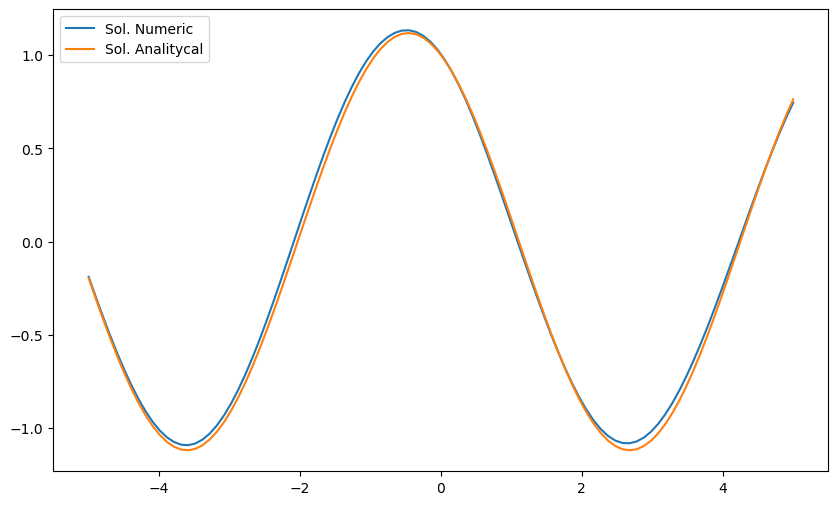

In [8]:
plt.figure(figsize=(10,6))
plt.plot(x_test,a)
plt.plot( x_test,np.cos(x)-(0.5)*np.sin(x))
legend = ['Sol. Numeric','Sol. Analitycal']
plt.legend(loc='upper left', labels= legend)
plt.show()
model.save("T3_RNA_EDO2.h5") 